#Tarea 2

Para utilizar este código basta con apretar 'Entorno de ejecución' -> Ejecutar todas y en la primera celda de código subir el archivo magic04.data

In [106]:
#subir archivo magic04.data
from google.colab import files
uploaded= files.upload()

Saving magic04.data to magic04 (4).data


In [107]:
%matplotlib inline
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import time
import sklearn

In [108]:
#Parte 2
nombres_columnas=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
data = pd.read_csv("magic04.data",names=nombres_columnas)
df= pd.DataFrame(data)
df['class'].replace('g',0, inplace = True)
df['class'].replace('h',1, inplace = True) 
reordenar = df
reordenar = reordenar.sample(frac=1,random_state=1).reset_index(drop=True)
clase_positiva=reordenar.loc[reordenar['class'] == 1] #hadrones
clase_negativa=reordenar.loc[reordenar['class'] == 0] #no hadrones
remuestreo= pd.concat([clase_positiva[:3000],clase_negativa[:3000]])
remuestreo = remuestreo.sample(frac=1,random_state=1).reset_index(drop=True)

In [109]:
#Parte 3
num_entr = int(len(remuestreo)*0.6) 
num_validacion = int(len(remuestreo)*0.2)
num_test= len(remuestreo)-num_entr-num_validacion

entrenamiento= remuestreo.iloc[0:num_entr]
validacion= remuestreo.iloc[num_entr:(num_entr+num_validacion)]
validacion= validacion.reset_index(drop=True)
test= remuestreo.iloc[(num_entr+num_validacion):]
test= test.reset_index(drop=True)

#proporcion conjunto completo
ratio_df= len(remuestreo.loc[remuestreo['class'] == 0])/len(remuestreo.loc[remuestreo['class'] == 1]) #proporcion de clases #0/#1
#poporcion conj entrenamiento
ratio_entrenamiento=len(entrenamiento.loc[entrenamiento['class']==0])/len(entrenamiento.loc[entrenamiento['class']==1])
print((abs(ratio_df-ratio_entrenamiento)/ratio_df)*100 ,'% de diferencia en representatividad para entrenamiento') #formula de error 
#poporcion conj validacion
ratio_validacion=len(validacion.loc[validacion['class']==0])/len(validacion.loc[validacion['class']==1])
print((abs(ratio_df-ratio_validacion)/ratio_df)*100 ,'% de diferencia en representatividad para validacion') #formula de error 

#poporcion conj testeo
ratio_test=len(test.loc[test['class']==0])/len(test.loc[test['class']==1])
print((abs(ratio_df-ratio_test)/ratio_df)*100 ,'% de diferencia en representatividad para test') #formula de error 

0.33388981636059967 % de diferencia en representatividad para entrenamiento
4.241435562805873 % de diferencia en representatividad para validacion
3.3898305084745672 % de diferencia en representatividad para test


In [110]:
#Parte 4
from sklearn import preprocessing
scaler= preprocessing.StandardScaler()
scaler_entrenado=scaler.fit(entrenamiento.iloc[:,:9]) #Entrenamiento de standardscaler

#Aplicación de standardscaler a conjuntos
scaled_entrenamiento= scaler.transform(entrenamiento.iloc[:,:9])
scaled_validacion= scaler.transform(validacion.iloc[:,:9]) 
scaled_test= scaler.transform(test.iloc[:,:9]) 

In [111]:
#Parte 5
from sklearn import svm
from sklearn.model_selection import GridSearchCV

tiempo_svmlineal_inicio = time.time()


parametros= {'C':[0.1, 0.25, 0.5, 0.75, 1]}
svmlineal = svm.SVC(kernel= 'linear', probability=False)
clfl = GridSearchCV(svmlineal, parametros, cv=5)
clfl.fit(scaled_entrenamiento,entrenamiento.iloc[:,10])
tiempo_svmlineal_final = time.time()
print(clfl.best_params_)



{'C': 0.25}


In [112]:
#Parte 6

y_pred_svml=clfl.predict(scaled_validacion)
#sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svml, normalize=None))
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svml, normalize='true'))

[[472 115]
 [161 452]]
[[0.80408859 0.19591141]
 [0.26264274 0.73735726]]


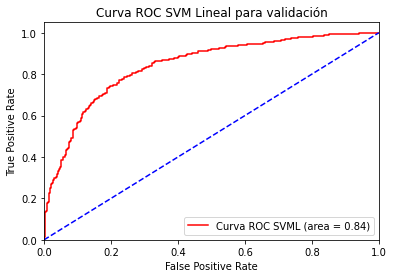

In [113]:
#Parte 7
from sklearn import metrics
y_score_svml=clf.decision_function(scaled_validacion)
#sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
fprl, tprl, thresholds = sklearn.metrics.roc_curve(validacion.iloc[:,10], y_score_svml)
area_bajo_curva_svml=metrics.auc(fprl, tprl)

plt.figure()

plt.plot(fprl, tprl, color='red', label='Curva ROC SVML (area = %0.2f)' % area_bajo_curva_svml)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM Lineal para validación')
plt.legend(loc="lower right")
plt.show()

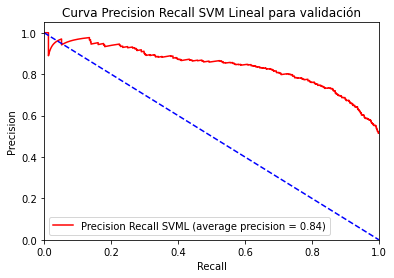

In [114]:
#Parte 8 
precisionl, recalll, thresholds = sklearn.metrics.precision_recall_curve(validacion.iloc[:,10], y_score_svml)
avg_ps_svml=sklearn.metrics.average_precision_score(validacion.iloc[:,10], y_score_svml)

plt.figure()

plt.plot(recalll,precisionl, color='red', label='Precision Recall SVML (average precision = %0.2f)' % avg_ps_svml)
plt.plot([0, 1], [1,0], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision Recall SVM Lineal para validación')
plt.legend(loc="lower left")
plt.show()

In [115]:
#Parte 9
#9.5
tiempo_svmpolinomial1_inicio = time.time()


parametrosp= {'degree':[2,3],'C':[0.1, 0.25, 0.75, 1],'gamma':['scale','auto',1/(len(entrenamiento)**2),1]}
svmpolinomial1 = svm.SVC(kernel= 'poly', probability=False)
clfp1 = GridSearchCV(svmpolinomial, parametrosp, cv=5)
clfp1.fit(scaled_entrenamiento,entrenamiento.iloc[:,10])

tiempo_svmpolinomial1_final = time.time()
print(clfp1.best_params_)


########Entrenamiento segundo svm polinomial########
tiempo_svmpolinomial2_inicio = time.time()
svmpolinomial2 = svm.SVC(kernel= 'poly', probability=False, degree= 2, gamma= 'scale')
svmpolinomial2.fit(scaled_entrenamiento,entrenamiento.iloc[:,10])
tiempo_svmpolinomial2_final = time.time()

{'C': 0.25, 'degree': 3, 'gamma': 1}


In [127]:
#9.6
print('Mejor SVM polinomial')
y_pred_svmp1=clfp1.predict(scaled_validacion)
#sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmp1, normalize=None))
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmp1, normalize='true'))

###########segundo svm polinomial
print('Otro SVM polinomial')
y_pred_svmp2=svmpolinomial2.predict(scaled_validacion)
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmp2, normalize=None))
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmp2, normalize='true'))


Mejor SVM polinomial
[[491  96]
 [121 492]]
[[0.83645656 0.16354344]
 [0.19738989 0.80261011]]
Otro SVM polinomial
[[504  83]
 [179 434]]
[[0.85860307 0.14139693]
 [0.29200653 0.70799347]]


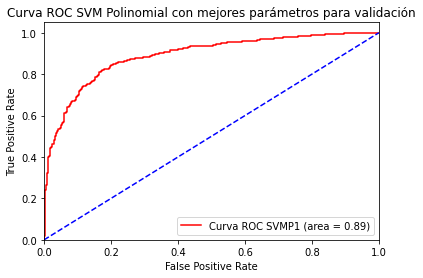

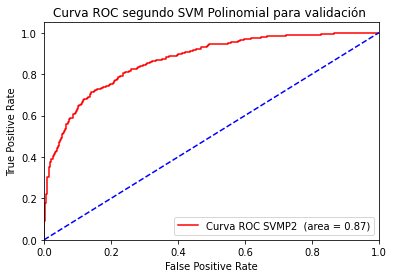

In [117]:
#9.7
y_score_svmp1=clfp1.decision_function(scaled_validacion)
fprp1, tprp1, thresholds = sklearn.metrics.roc_curve(validacion.iloc[:,10], y_score_svmp1)
area_bajo_curva_svmp1=metrics.auc(fprp1, tprp1)

plt.figure()

plt.plot(fprp1, tprp1, color='red', label='Curva ROC SVMP1 (area = %0.2f)' % area_bajo_curva_svmp1)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM Polinomial con mejores parámetros para validación')
plt.legend(loc="lower right")
plt.show()

##########segundo svm polinomial

y_score_svmp2=svmpolinomial2.decision_function(scaled_validacion)
fprp2, tprp2, thresholds = sklearn.metrics.roc_curve(validacion.iloc[:,10], y_score_svmp2)
area_bajo_curva_svmp2=metrics.auc(fprp2, tprp2)

plt.figure()

plt.plot(fprp2, tprp2, color='red', label='Curva ROC SVMP2  (area = %0.2f)' % area_bajo_curva_svmp2)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC segundo SVM Polinomial para validación ')
plt.legend(loc="lower right")
plt.show()

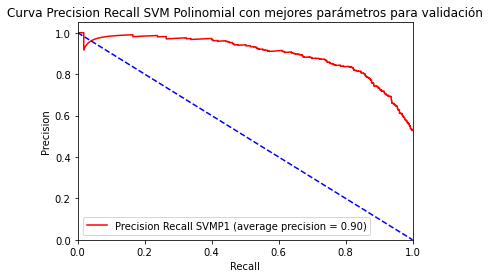

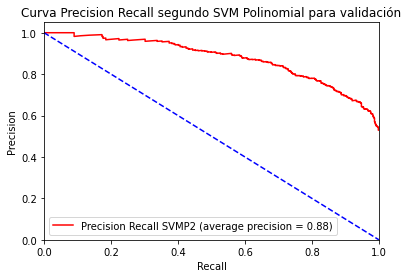

In [118]:
#9.8 
precisionp, recallp, thresholds = sklearn.metrics.precision_recall_curve(validacion.iloc[:,10], y_score_svmp)
avg_ps_svmp=sklearn.metrics.average_precision_score(validacion.iloc[:,10], y_score_svmp)

plt.figure()

plt.plot(recallp,precisionp, color='red', label='Precision Recall SVMP1 (average precision = %0.2f)' % avg_ps_svmp)
plt.plot([0, 1], [1,0], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision Recall SVM Polinomial con mejores parámetros para validación')
plt.legend(loc="lower left")
plt.show()


#############Segundo SVM polinomial

precisionp2, recallp2, thresholds = sklearn.metrics.precision_recall_curve(validacion.iloc[:,10], y_score_svmp2)
avg_ps_svmp2=sklearn.metrics.average_precision_score(validacion.iloc[:,10], y_score_svmp2)

plt.figure()

plt.plot(recallp2,precisionp2, color='red', label='Precision Recall SVMP2 (average precision = %0.2f)' % avg_ps_svmp2)
plt.plot([0, 1], [1,0], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision Recall segundo SVM Polinomial para validación')
plt.legend(loc="lower left")
plt.show()


In [119]:
#Parte 10
#10.5
tiempo_svmrbf_inicio = time.time()


parametrosrbf= {'C':[0.1, 0.25,0.5, 0.75, 1],'gamma':['scale','auto',1/(len(entrenamiento)**2),1]}
svmrbf = svm.SVC(kernel= 'rbf', probability=False)
clfrbf = GridSearchCV(svmrbf, parametrosrbf, cv=5)
clfrbf.fit(scaled_entrenamiento,entrenamiento.iloc[:,10])
tiempo_svmrbf_final = time.time()
print(clfrbf.best_params_)


{'C': 0.75, 'gamma': 'auto'}


In [120]:
#10.6
y_pred_svmrbf=clfrbf.predict(scaled_validacion)
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmrbf, normalize=None))
print(sklearn.metrics.confusion_matrix(validacion.iloc[:,10], y_pred_svmrbf, normalize='true'))

[[507  80]
 [122 491]]
[[0.8637138  0.1362862 ]
 [0.19902121 0.80097879]]


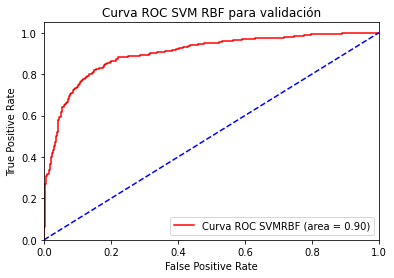

In [121]:
#10.7
y_score_svmrbf=clfrbf.decision_function(scaled_validacion)
fprrbf, tprrbf, thresholds = sklearn.metrics.roc_curve(validacion.iloc[:,10], y_score_svmrbf)
area_bajo_curva_svmrbf=metrics.auc(fprrbf, tprrbf)

plt.figure()

plt.plot(fprrbf, tprrbf, color='red', label='Curva ROC SVMRBF (area = %0.2f)' % area_bajo_curva_svmrbf)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM RBF para validación')
plt.legend(loc="lower right")
plt.show()

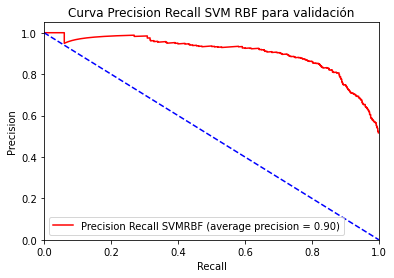

In [122]:
#10.8
precisionrbf, recallrbf, thresholdsrbf = sklearn.metrics.precision_recall_curve(validacion.iloc[:,10], y_score_svmrbf)
avg_ps_svmrbf=sklearn.metrics.average_precision_score(validacion.iloc[:,10], y_score_svmrbf)

plt.figure()

plt.plot(recallrbf,precisionrbf, color='red', label='Precision Recall SVMRBF (average precision = %0.2f)' % avg_ps_svmrbf)
plt.plot([0, 1], [1,0], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision Recall SVM RBF para validación')
plt.legend(loc="lower left")
plt.show()

In [123]:
#Parte 11
#11.6
#lineal
print('Matriz de confusión SVM lineal en test')
y_pred_svml_test=clfl.predict(scaled_test)
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svml_test, normalize=None))
print('Normalizada')
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svml_test, normalize='true'))

#polinomios
print('Matriz de confusión SVM de mejor polinomio en test')
y_pred_svmp1_test=clfp1.predict(scaled_test)
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmp1_test, normalize=None))
print('Normalizada')
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmp1_test, normalize='true'))

###########segundo svm polinomial
print('Matriz de confusión SVM de segundo polinomio en test')
y_pred_svmp2_test=svmpolinomial2.predict(scaled_test)
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmp2_test, normalize=None))
print('Normalizada')
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmp2_test, normalize='true'))

##############rbf
print('Matriz de confusión SVM RBF en test')
y_pred_svmrbf_test=clfrbf.predict(scaled_test)
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmrbf_test, normalize=None))
print('Normalizada')
print(sklearn.metrics.confusion_matrix(test.iloc[:,10], y_pred_svmrbf_test, normalize='true'))

Matriz de confusión SVM lineal en test
[[484 126]
 [149 441]]
Normalizada
[[0.79344262 0.20655738]
 [0.25254237 0.74745763]]
Matriz de confusión SVM de mejor polinomio en test
[[501 109]
 [120 470]]
Normalizada
[[0.82131148 0.17868852]
 [0.20338983 0.79661017]]
Matriz de confusión SVM de segundo polinomio en test
[[509 101]
 [186 404]]
Normalizada
[[0.83442623 0.16557377]
 [0.31525424 0.68474576]]
Matriz de confusión SVM RBF en test
[[519  91]
 [117 473]]
Normalizada
[[0.85081967 0.14918033]
 [0.19830508 0.80169492]]


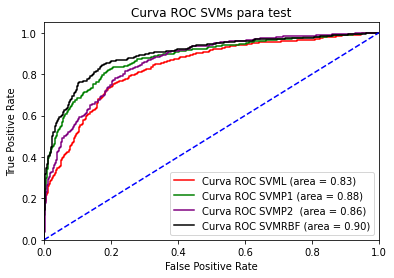

In [124]:
#11.7

#lineal
y_score_svml_test=clf.decision_function(scaled_test)
fprl_test, tprl_test, thresholds = sklearn.metrics.roc_curve(test.iloc[:,10], y_score_svml_test)
area_bajo_curva_svml_test=metrics.auc(fprl_test, tprl_test)

#mejor polinomio
y_score_svmp1_test=clfp1.decision_function(scaled_test)
fprp1_test, tprp1_test, thresholds = sklearn.metrics.roc_curve(test.iloc[:,10], y_score_svmp1_test)
area_bajo_curva_svmp1_test=metrics.auc(fprp1_test, tprp1_test)

#segundo svm polinomial
y_score_svmp2_test=svmpolinomial2.decision_function(scaled_test)
fprp2_test, tprp2_test, thresholds = sklearn.metrics.roc_curve(test.iloc[:,10], y_score_svmp2_test)
area_bajo_curva_svmp2_test=metrics.auc(fprp2_test, tprp2_test)

#RBF
y_score_svmrbf_test=clfrbf.decision_function(scaled_test)
fprrbf_test, tprrbf_test, thresholds = sklearn.metrics.roc_curve(test.iloc[:,10], y_score_svmrbf_test)
area_bajo_curva_svmrbf_test=metrics.auc(fprrbf_test, tprrbf_test)




plt.figure()

plt.plot(fprl_test, tprl_test, color='red', label='Curva ROC SVML (area = %0.2f)' % area_bajo_curva_svml_test)
plt.plot(fprp1_test, tprp1_test, color='green', label='Curva ROC SVMP1 (area = %0.2f)' % area_bajo_curva_svmp1_test)
plt.plot(fprp2_test, tprp2_test, color='purple', label='Curva ROC SVMP2  (area = %0.2f)' % area_bajo_curva_svmp2_test)
plt.plot(fprrbf_test, tprrbf_test, color='black', label='Curva ROC SVMRBF (area = %0.2f)' % area_bajo_curva_svmrbf_test)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVMs para test')
plt.legend(loc="lower right")
plt.show()



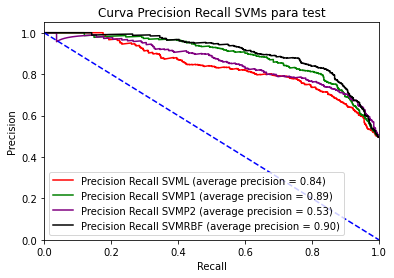

In [125]:
#11.8
#lineal
precisionl_test, recalll_test, thresholds = sklearn.metrics.precision_recall_curve(test.iloc[:,10], y_score_svml_test)
avg_ps_svml_test=sklearn.metrics.average_precision_score(test.iloc[:,10], y_score_svml_test)

#mejor polinomio
precisionp1_test, recallp1_test, thresholds = sklearn.metrics.precision_recall_curve(test.iloc[:,10], y_score_svmp1_test)
avg_ps_svmp1_test=sklearn.metrics.average_precision_score(test.iloc[:,10], y_score_svmp1_test)

#segundo polinomio
precisionp2_test, recallp2_test, thresholds = sklearn.metrics.precision_recall_curve(test.iloc[:,10], y_score_svmp2_test)
avg_ps_svmp2_test=sklearn.metrics.average_precision_score(validacion.iloc[:,10], y_score_svmp2_test)

#RBF
precisionrbf_test, recallrbf_test, thresholdsrbf = sklearn.metrics.precision_recall_curve(test.iloc[:,10], y_score_svmrbf_test)
avg_ps_svmrbf_test=sklearn.metrics.average_precision_score(test.iloc[:,10], y_score_svmrbf_test)




plt.figure()

plt.plot(recalll_test,precisionl_test, color='red', label='Precision Recall SVML (average precision = %0.2f)' % avg_ps_svml_test)
plt.plot(recallp1_test,precisionp1_test, color='green', label='Precision Recall SVMP1 (average precision = %0.2f)' % avg_ps_svmp1_test)
plt.plot(recallp2_test,precisionp2_test, color='purple', label='Precision Recall SVMP2 (average precision = %0.2f)' % avg_ps_svmp2_test)
plt.plot(recallrbf_test,precisionrbf_test, color='black', label='Precision Recall SVMRBF (average precision = %0.2f)' % avg_ps_svmrbf_test)
plt.plot([0, 1], [1,0], color='blue',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision Recall SVMs para test')
plt.legend(loc="lower left")
plt.show()

In [126]:
#Tiempos de entrenamiento
print('Tiempos de entrenamiento')
print('Tiempo SVM lineal: ',tiempo_svmlineal_final-tiempo_svmlineal_inicio,'[s]')
print('Tiempo mejor SVM polinomial: ',tiempo_svmpolinomial1_final-tiempo_svmpolinomial1_inicio,'[s]')
print('Tiempo SVM polinomial sin grillar: ',tiempo_svmpolinomial2_final-tiempo_svmpolinomial2_inicio,'[s]')
print('Tiempo SVM RBF: ',tiempo_svmrbf_final-tiempo_svmrbf_inicio,'[s]')

Tiempos de entrenamiento
Tiempo SVM lineal:  4.981053590774536 [s]
Tiempo mejor SVM polinomial:  93.10271787643433 [s]
Tiempo SVM polinomial sin grillar:  0.2607443332672119 [s]
Tiempo SVM RBF:  34.94711875915527 [s]
